## Modelling workflow

### Load Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

### Prep data

In [140]:
df = pd.read_csv('../00_data/train.csv')

model_cols = ['age_filled', 'Embarked', 'Pclass', 'Sex', 'Fare']


# impute mean age by Survival and class
df['age_filled']= df.groupby(['Survived', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.mean()))

X, y = df.drop('Survived',axis = 1)[model_cols], df.Survived


### Split Data


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X[model_cols], y, test_size=0.25)

### Feature Engineering

#### Define Transformers

In [4]:

embark_na_hot = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)


# make a columntrans pipeline
fullTransform = ColumnTransformer([
    ('age_select', 'passthrough', ['age_filled']),
    ('embark_na_hot', embark_na_hot, ['Embarked']),
   ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Pclass', 'Sex']),
    ('fare_scale', MinMaxScaler(feature_range= (0,1)), ['Fare'])
],
remainder = 'drop')

#### Apply Transformations

In [5]:
X_train_trans = fullTransform.fit_transform(X = X_train)
print(X_train_trans.shape)
X_train_trans

(668, 10)


array([[2.06461176e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.51757893e-02],
       [1.70000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 2.34224401e-02],
       [3.30000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 1.03644297e-01],
       ...,
       [4.90000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.65555556e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 2.94732371e-02],
       [1.80000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 2.24465051e-02]])

Get a data frame with transformed column names for later

In [6]:
## from https://lifesaver.codes/answer/cannot-get-feature-names-after-columntransformer-12525


def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    # for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
    for transformer_in_columns in column_transformer.transformers_ :#adjusted this line - seems to drop the last transformer, not only remainder
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name



# print(full_transformer.fit_transform(X_train).shape[1], len(get_column_names_from_ColumnTransformer(full_transformer)))


In [7]:
mod_df = pd.DataFrame(
    fullTransform.transform(X = X_train),
    columns = get_column_names_from_ColumnTransformer(fullTransform)
    )


# print(get_column_names_from_ColumnTransformer(fullTransform))
# fullTransform.transformers_[:-1][1][1].steps[1][1].get_feature_names()



### Make predictions on new data

## Apply LogReg

In [8]:
m = LogisticRegression( class_weight= 'balanced')

# fit model
m.fit(X_train_trans, y_train)

# inspect results
m.coef_, m.intercept_

LogisticRegression(class_weight='balanced')

#### Check scores

In [9]:
m.score(fullTransform.transform(X = X_train), y_train), m.score(fullTransform.transform(X = X_test), y_test)

(0.7889221556886228, 0.8565022421524664)

### Make predictions on new data

- make a model grid for:
    - all ages
    - all PClasses
    - all sexes 
    - median Fare
    - Embarked == Q


**Use helper function to create the 'grid'**

In [10]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,age_filled
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,29.347365
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,13.319172
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.420000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,21.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,26.555556
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,36.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,80.000000


In [27]:
import itertools
def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())



new_data = expand_grid(
    {
        'age_filled' : np.linspace(1, 80, 100), # this will get changed into groups
        'Pclass' : [1,2,3],
        'Sex' : ['male', 'female'],
        # 'Fare' : [5],
        'Fare' : [round(np.median(df.Fare))],
        'Embarked' : ['Q', 'C', 'S']
    }
)[model_cols]

new_data


,age_filled,Embarked,Pclass,Sex,Fare
0,1.0,Q,1,male,14
1,1.0,C,1,male,14
2,1.0,S,1,male,14
3,1.0,Q,1,female,14
4,1.0,C,1,female,14
...,...,...,...,...,...
1795,80.0,C,3,male,14
1796,80.0,S,3,male,14
1797,80.0,Q,3,female,14
1798,80.0,C,3,female,14


In [145]:
X_new = fullTransform.transform(X = new_data)
y_pred = m.predict(X_new)
y_prob = m.predict_proba(X_new)[:,1] # for survived probability


# make a neat df for plotting
mod_df_plot = pd.concat(
    [
        new_data,
        pd.Series(y_pred, name = 'Survived'),
        pd.Series(y_prob, name = 'Survived_prob') 
    ],
    axis = 1)
# mod_df_plot['Survived'] = mod_df_plot['Survived'] == True

mod_df_plot



# grab unmodelled original data


mod_df_plot_original = df[model_cols + ['Survived']]

In [146]:
# mod_df_plot_original.Pclass.unique()

array([3, 1, 2])

### Plot some results

(122, 6)
(108, 6)
(347, 6)
(94, 6)
(76, 6)
(144, 6)


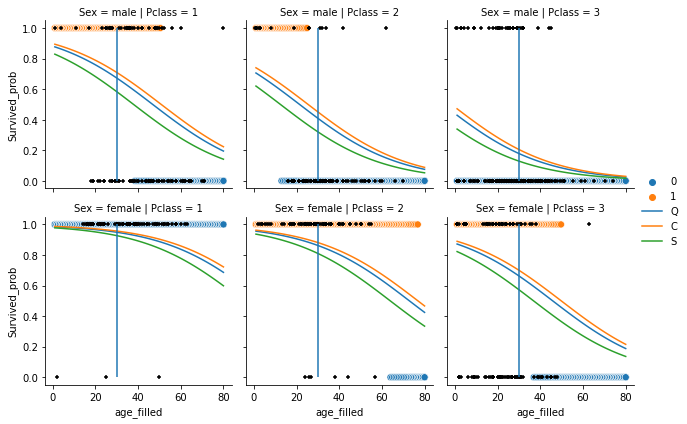

In [149]:
# Alternative with less clutter

g = sns.FacetGrid(mod_df_plot, col="Pclass", row = 'Sex')
g.map(sns.scatterplot, 
    'age_filled',
    'Survived', 
    'Survived',
    s = 50
)


g.map(sns.lineplot, 
    'age_filled',
    'Survived_prob',
    'Embarked'
    )

# grab all facets
axes = g.fig.axes


# use regular expression to get class info from titles of facets
import re

# iterate over facets (= axes)
for ax in axes:

    # split facet titles
    title = ax.get_title()
    rx = re.findall('(?<=[=][ ])\w+', title)
    sex = rx[0]
    pclass = int(rx[1])




    # make data subset
    dtemp = mod_df_plot_original.loc[
            (mod_df_plot_original.Sex == sex) &
            (mod_df_plot_original.Pclass == pclass), :]

    print(dtemp.shape)

    # add original data
    ax.scatter(
        x = dtemp['age_filled'],
        y = dtemp['Survived'],
        c = 'black',
        marker = '+',
        s = 10
    )




g.add_legend()



In [36]:
y_pred = m.predict(fullTransform.transform(X = X))
y_prob = m.predict_proba(fullTransform.transform(X = X))[:,1] # for survived probability


# make a neat df for plotting
mod_df_plot = pd.concat(
    [
        X,
        pd.Series(y, name = 'Survived_actual'),
        pd.Series(y_pred, name = 'Survived'),
        pd.Series(y_prob, name = 'Survived_prob') 
    ],
    axis = 1)
# mod_df_plot['Survived'] = mod_df_plot['Survived'] == True

mod_df_plot

,age_filled,Embarked,Pclass,Sex,Fare,Survived_actual,Survived,Survived_prob
0,22.000000,S,3,male,7.2500,0,0,0.172105
1,38.000000,C,1,female,71.2833,1,1,0.941750
2,26.000000,S,3,female,7.9250,1,1,0.612899
3,35.000000,S,1,female,53.1000,1,1,0.912659
4,35.000000,S,3,male,8.0500,0,0,0.106545
...,...,...,...,...,...,...,...,...
886,27.000000,S,2,male,13.0000,0,0,0.349276
887,19.000000,S,1,female,30.0000,1,1,0.953392
888,26.555556,S,3,female,23.4500,0,1,0.609298
889,26.000000,C,1,male,30.0000,1,1,0.745059


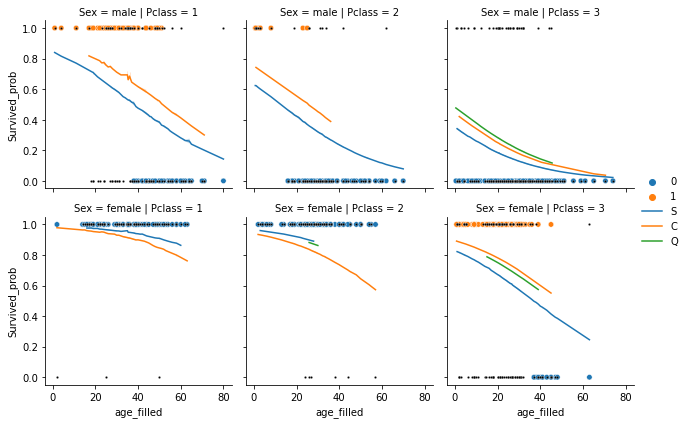

In [42]:
# Alternative with less clutter

g = sns.FacetGrid(mod_df_plot, col="Pclass", row = 'Sex')
g.map(sns.scatterplot, 
    'age_filled',
    'Survived', 
    'Survived',
    s = 30
)



g.map(sns.scatterplot, 
    'age_filled',
    'Survived_actual', 
    color = 'black',
    s = 5
)

g.map(sns.lineplot, 
    'age_filled',
    'Survived_prob',
    'Embarked'
    )

g.add_legend()

